# Computing Partials and Amplitudes 

In [45]:
import librosa
import librosa.display
import numpy as np
import os
from IPython import display as ipd
from scipy.io import wavfile
import matplotlib.pyplot as plt
import scipy
import pandas as pd
from scipy.signal import resample

from libsoni.core.methods import generate_tone_additive_synthesis
from libsoni.util.utils import normalize_signal, fade_signal, mix_sonification_and_original

%matplotlib inline

In [46]:
def pitch_to_frequency(pitch):
    return  440.0  * 2 ** ((pitch - 69) / 12)
def get_pitch_from_samplename(sample):
    return int(sample[7:10])
def get_folder_from_samplename(sample):
    return sample[:2]

In [47]:
#'01Pia1F069m_np___0.wav'
#'02Vio1F069m_np___0.wav'
#'03Cel1F069m_np___0.wav'
#'04Con1F060m_np___0.wav'
#'05Tru1M069m_np___0.wav'
#'06Tro1F069m_np___0.wav'
#'07Hor1F069m_np___0.wav'
#'08Obo1F069m_np___0.wav'
#'09Bas1F069m_np___0.wav'
#'10Cla1F069m_np___0.wav'
#'11Flu1F069m_np___0.wav'

# loading the audio sample
Sample = '11Flu1F069m_np___0.wav'
SAMPLE_DIR = os.path.join('..','SNDB',get_folder_from_samplename(Sample), Sample)

## Load Sample

In [48]:
pitch_sample = get_pitch_from_samplename(Sample)
f_sample = pitch_to_frequency(pitch_sample)
x, Fs = librosa.load(SAMPLE_DIR)

x = x[:3*Fs]
x = normalize_signal(x)
print('Loaded sample: %s' % Sample)
ipd.display(ipd.Audio(x, rate=Fs))

Loaded sample: 11Flu1F069m_np___0.wav


## Performing FFT

Frequency resolution: 1.35 Hz


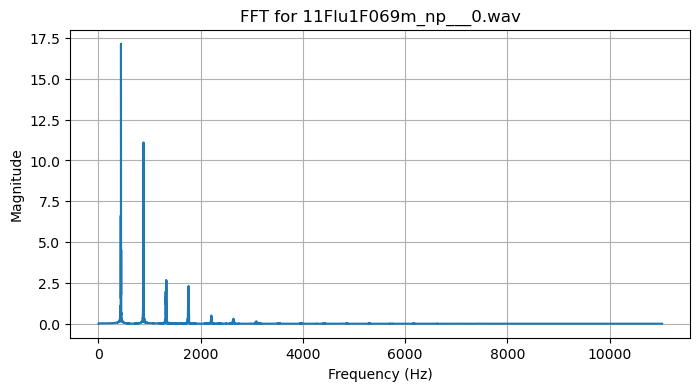

In [49]:
# Define Length of FFT
N_fft = 4096*4

# Perform FFT
X = np.fft.fft(x, n = N_fft, norm='ortho')

# Frequency resolution
print('Frequency resolution: %.2f Hz' %(Fs / N_fft))

# Calculate magnitudes
magnitude = np.abs(X)

# Frequency coefficients
frequencies = np.fft.fftfreq(len(magnitude), 1 / Fs)
phase = np.angle(X)

# Keep only the positive frequencies
frequencies = frequencies[:len(frequencies) // 2]
magnitude = magnitude[:len(magnitude) // 2]
phase = phase[:len(phase) // 2]

plt.figure(figsize=(8, 4))
plt.plot(frequencies,magnitude)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
#plt.yscale('log')
plt.title('FFT for %s' %Sample )
plt.grid(True)
plt.show()

In [50]:
# Define number of peaks to encounter for partials
N = 100

# Find N highest peaks of FFT
ind = np.argpartition(magnitude, -N)[-N:]

# Get parameters for synthesis
frequencies_synthesis = frequencies[ind]
magnitudes_synthesis = magnitude[ind]
phases_synthesis = phase[ind]

partials = frequencies_synthesis / f_sample
partials_amplitude = magnitudes_synthesis
partials_phase_offsets=phases_synthesis


# perform synthesis
resyn_1 = generate_tone_additive_synthesis(pitch=pitch_sample,
                                       partials=partials,
                                       partials_amplitudes=partials_amplitude,
                                       partials_phase_offsets=partials_phase_offsets,
                                       duration_sec = 3.0)

resyn_1 = normalize_signal(resyn_1)

print('Re-synthesized sample using %s peaks of fft:' %N)
ipd.display(ipd.Audio(resyn_1, rate=Fs))

Re-synthesized sample using 100 peaks of fft:


In [51]:
for N in [1,5,10,50,100,200]:
    # Find N peaks in FFT
    ind = np.argpartition(magnitude, -N)[-N:]
    
    # Get parameters for synthesis
    frequencies_synthesis = frequencies[ind]
    magnitudes_synthesis = magnitude[ind]
    phases_synthesis = phase[ind]
    
    partials = frequencies_synthesis / f_sample
    partials_amplitude = magnitudes_synthesis
    partials_phase_offsets=phases_synthesis

    # perform synthesis
    resyn_N = generate_tone_additive_synthesis(pitch=pitch_sample,
                                           partials=partials,
                                           partials_amplitudes=partials_amplitude,
                                           partials_phase_offsets=partials_phase_offsets,
                                           duration_sec = 3.0)
    
    resyn_N = normalize_signal(resyn_N)
    
    print('Re-synthesized Sample using %s peaks of fft:' %N)
    ipd.display(ipd.Audio(resyn_N, rate=Fs))

Re-synthesized Sample using 1 peaks of fft:


Re-synthesized Sample using 5 peaks of fft:


Re-synthesized Sample using 10 peaks of fft:


Re-synthesized Sample using 50 peaks of fft:


Re-synthesized Sample using 100 peaks of fft:


Re-synthesized Sample using 200 peaks of fft:


## Different Approach: Search Peaks in Octave-Subbands

#sinusoids: 60


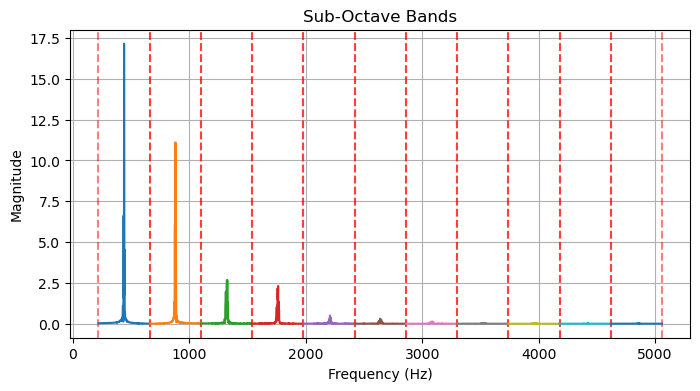

In [52]:
# Define the number of octave bands
num_octave_bands = 12
num_peaks_per_octave_band = 5
print('#sinusoids: %s' % int(num_octave_bands*num_peaks_per_octave_band))
# Calculate the center frequencies of the octave bands
center_frequencies = [f_sample * i for i in range(1, num_octave_bands)]


plt.figure(figsize=(8, 4))

partials = []
partials_amplitude = []
partials_phase_offsets = []

for center_freq in center_frequencies:

    lower_freq = center_freq - f_sample / 2
    upper_freq = center_freq + f_sample / 2
        
    band_indices = np.where((frequencies >= lower_freq) & (frequencies < upper_freq))
 
    frequencies_band = frequencies[band_indices]
    magnitude_band = magnitude[band_indices]
    phases_band = phase[band_indices]

    plt.axvline(lower_freq, color='r', linestyle='--', alpha=0.5)
    plt.axvline(upper_freq, color='r', linestyle='--', alpha=0.5)
    plt.plot(frequencies[band_indices],magnitude[band_indices])

    ind = np.argpartition(magnitude_band, -num_peaks_per_octave_band)[-num_peaks_per_octave_band:]

    partials.append(frequencies_band[ind][0]/f_sample)
    partials_amplitude.append(np.sum(magnitude_band))
    partials_phase_offsets.append(phases_band[ind][0])
    

resyn_2 = generate_tone_additive_synthesis(pitch=pitch_sample,
                                           partials=partials,
                                           partials_amplitudes=partials_amplitude,
                                           partials_phase_offsets=partials_phase_offsets,
                                           duration_sec = 3.0)

resyn_2 = normalize_signal(resyn_2)

ipd.display(ipd.Audio(resyn_2, rate=Fs))
plt.plot()
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.title('Sub-Octave Bands')
plt.grid(True)
plt.show()

Sonified with Additive Synthesis:


Sonified with Additive Synthesis:


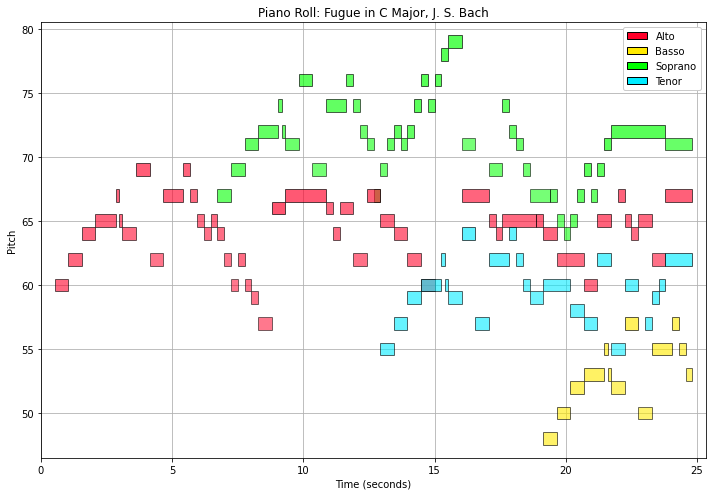

In [53]:
from libsoni.core.pianoroll import sonify_pianoroll_additive_synthesis, \
                                   sonify_pianoroll_fm_synthesis, \
                                   sonify_pianoroll_clicks, \
                                   sonify_pianoroll_sample, \
                                   visualize_pianoroll

from libsoni.core.tse import sonify_tse_clicks
from libsoni.util.utils import mix_sonification_and_original, get_preset

bach_df = pd.read_csv(os.path.join('data_csv',
                                   'demo_pianoroll',
                                   'FMP_C1_F12_Bach_BWV846_Sibelius-Tracks.csv'),delimiter=';')

bach_audio, _ = librosa.load(os.path.join('data_audio',
                                          'demo_pianoroll',
                                          'FMP_C1_F12_Bach_BWV846_Sibelius-Tracks.wav'))

visualize_pianoroll(bach_df, figsize=(10, 7), colors='gist_rainbow', title='Piano Roll: Fugue in C Major, J. S. Bach');

# Additive Synthesis

sonified_bach_as = sonify_pianoroll_additive_synthesis(pianoroll_df=bach_df,
                                                       partials=partials,
                                                       partials_amplitudes=partials_amplitude,
                                                       partials_phase_offsets=partials_phase_offsets)

sonified_bach_as_w_original = mix_sonification_and_original(sonification=sonified_bach_as,
                                                            original_audio=bach_audio,
                                                            gain_lin_original_audio=0.25,
                                                            panning=0)


print('Sonified with Additive Synthesis:')
ipd.display(ipd.Audio(sonified_bach_as, rate=Fs))


print('Sonified with Additive Synthesis:')
ipd.display(ipd.Audio(sonified_bach_as_w_original, rate=Fs))


In [54]:
def resynthesize(sample, num_octave_bands = 12, num_peaks_per_octave_band = 1, target_sample=69):
    SAMPLE_DIR = os.path.join('..','SNDB',get_folder_from_samplename(sample), sample)
    
    pitch_sample = get_pitch_from_samplename(sample)
    
    f_sample = pitch_to_frequency(pitch_sample)
    x, Fs = librosa.load(SAMPLE_DIR)
    # Define Length of FFT
    N_fft = 4096*8
    
    # Perform FFT to obtain the frequency domain representation
    X = np.fft.fft(x, n = N_fft, norm='ortho')
    
    # Calculate the magnitudes of the FFT coefficients
    magnitude = np.abs(X)
    
    # Find the frequencies corresponding to each FFT coefficient
    frequencies = np.fft.fftfreq(len(magnitude), 1 / Fs)
    
    phase = np.angle(X)
    
    
    frequencies = frequencies[:len(frequencies) // 2]
    magnitude = magnitude[:len(magnitude) // 2]
    phase = phase[:len(phase) // 2]
    # Calculate the center frequencies of the octave bands
    center_frequencies = [f_sample * i for i in range(1, num_octave_bands)]
    
    partials = []
    partials_amplitude = []
    partials_phase_offsets = []
    
    for center_freq in center_frequencies:
    
        lower_freq = center_freq - f_sample / 2
        upper_freq = center_freq + f_sample / 2
            
        band_indices = np.where((frequencies >= lower_freq) & (frequencies < upper_freq))
     
        frequencies_band = frequencies[band_indices]
        magnitude_band = magnitude[band_indices]
        phases_band = phase[band_indices]
    
        ind = np.argpartition(magnitude_band, -num_peaks_per_octave_band)[-num_peaks_per_octave_band:]
    
        partials.append(frequencies_band[ind][0]/f_sample)
        partials_amplitude.append(magnitude_band[ind][0])
        partials_phase_offsets.append(phases_band[ind][0])
        
    
    resyn_2 = generate_tone_additive_synthesis(pitch=target_sample,
                                               partials=partials,
                                               partials_amplitudes=partials_amplitude,
                                               partials_phase_offsets=partials_phase_offsets,
                                               duration_sec = 3.0)
    
    return normalize_signal(resyn_2)

In [55]:
samples = [
    '01Pia1F069m_np___0.wav',
    '02Vio1F069m_np___0.wav',
    '03Cel1F069m_np___0.wav',
    '04Con1F060m_np___0.wav',
    '05Tru1M069m_np___0.wav',
    '06Tro1F069m_np___0.wav',
    '07Hor1F069m_np___0.wav',
    '08Obo1F069m_np___0.wav',
    '09Bas1F069m_np___0.wav',
    '10Cla1F069m_np___0.wav',
    '11Flu1F069m_np___0.wav'
    ]

for sample in samples:
    print(sample[2:5])
    resynthesized_audio = resynthesize(sample, num_octave_bands = 10, num_peaks_per_octave_band = 10, target_sample= 69-12)
    ipd.display(ipd.Audio(resynthesized_audio, rate=Fs))

Pia


Vio


Cel


Con


Tru


Tro


Hor


Obo


Bas


Cla


Flu


## How can we get to envelopes?


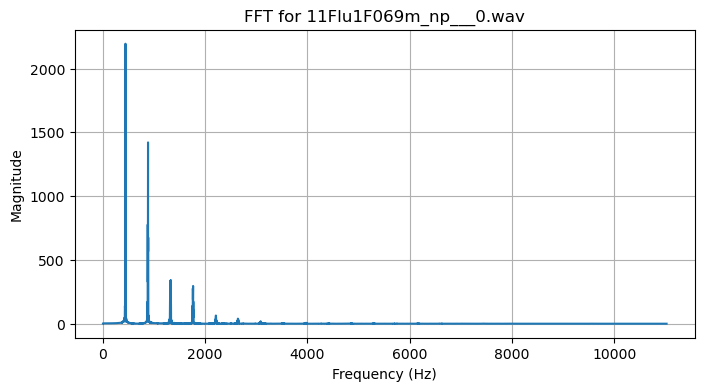

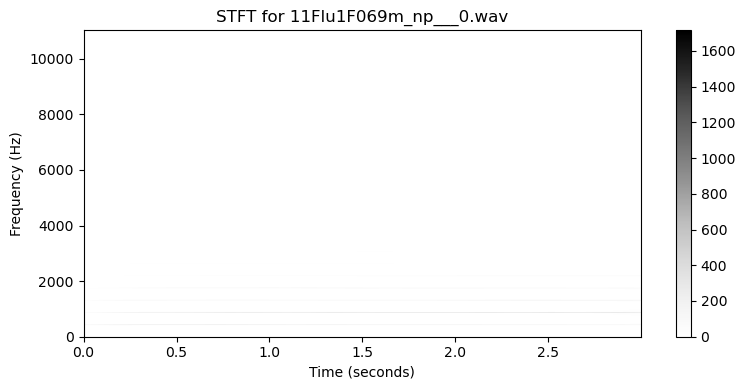

In [56]:
N = 4096*4
H = 64

# Perform FFT 
X_fft = np.fft.fft(x, n = N)

# Calculate the magnitudes of the FFT coefficients
X_fft_mag = np.abs(X_fft)

# Find the frequencies corresponding to each FFT coefficient
F_coef_fft = np.fft.fftfreq(len(X_fft_mag), 1 / Fs)
Phase_coef_fft = np.angle(X_fft)

# Keep only the positive frequencies
F_coef_fft = F_coef_fft[:len(F_coef_fft) // 2]
X_fft_mag = X_fft_mag[:len(X_fft_mag) // 2]
Phase_coef_fft = Phase_coef_fft[:len(Phase_coef_fft) // 2]

# Plot FFT
plt.figure(figsize=(8, 4))
plt.plot(F_coef_fft,X_fft_mag)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.title('FFT for %s' %Sample )
plt.grid(True)
plt.show()


# Perform STFT
X_stft = librosa.stft(x, n_fft= N, hop_length=H)

# Calculate the magnitude of the STFT
X_stft_mag = np.abs(X_stft)

# Calculate log-compressed version of the STFT
X_stft_mag_log = np.log(1 + 100 * np.abs(X_stft_mag) ** 2)

# Calculate frequency coefficients of STFT
F_coef_stft = np.fft.fftfreq(len(X_stft_mag), 1 / Fs)
F_coef_stft = F_coef_stft[:len(F_coef_stft) // 2]

# Calculate time coefficients of STFT
T_coef_stft = np.arange(X_stft_mag.shape[1]) * H / Fs


# Plot STFT
plt.figure(figsize=(8, 4))
plt.imshow(X_stft_mag, cmap='Greys', aspect='auto', origin='lower',extent=[T_coef_stft[0], T_coef_stft[-1], F_coef_stft[0], F_coef_stft[-1]])
plt.xlabel('Time (seconds)')
plt.ylabel('Frequency (Hz)')
plt.title('STFT for %s' %Sample )
plt.colorbar()
plt.tight_layout()
plt.show()

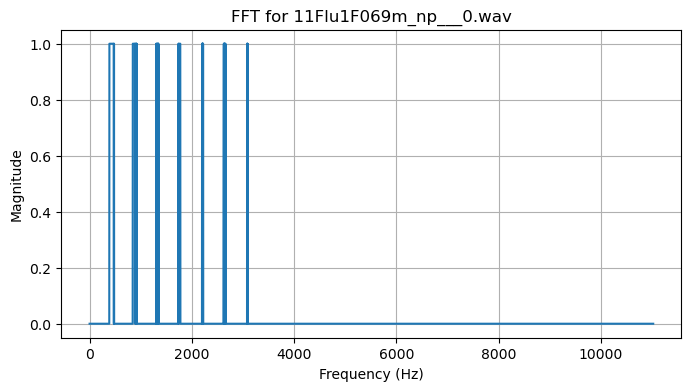

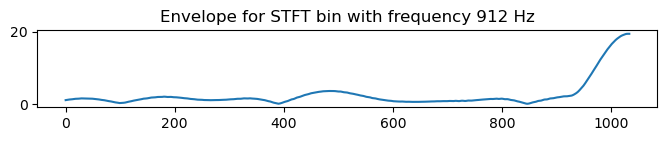

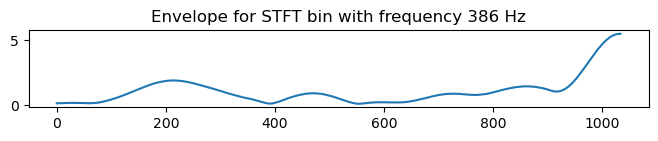

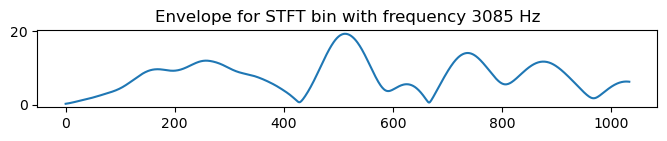

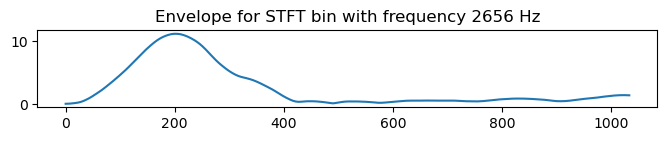

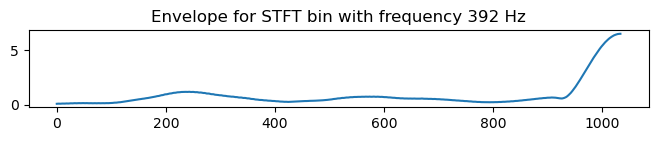

In [57]:
# Define number of peaks to encounter for partials
N_peaks = 200

# Find N peaks in FFT
ind_peaks = np.argpartition(X_fft_mag, -N_peaks)[-N_peaks:]



spectrum_additive = np.zeros_like(X_fft_mag)
spectrum_additive[ind_peaks] = 1

# Plot FFT
plt.figure(figsize=(8, 4))
plt.plot(F_coef_fft,spectrum_additive)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.title('FFT for %s' %Sample )
plt.grid(True)
plt.show()

for i, ind_peak in enumerate(ind_peaks):
    
    frequency_peak = ind_peak * (Fs / N_fft)
    plt.figure(figsize=(8, 1))
    plt.title('Envelope for STFT bin with frequency %i Hz' %frequency_peak)
    plt.plot(X_stft_mag[ind_peak,:])
    plt.show()
    if i == 4: break

In [58]:
def generate_tone_additive_synthesis_w_envelopes(pitch: int = 69,
                                     partials: np.ndarray = np.array([1]),
                                     partials_amplitudes: np.ndarray = None,
                                     partials_phase_offsets: np.ndarray = None,
                                     envelopes: np.ndarray = None,
                                     gain: float = 1.0,
                                     duration_sec: float = 1.0,
                                     fs: int = 22050,
                                     f_tuning: float = 440,
                                     fading_sec: float = 0.01) -> np.ndarray:
    """Generates signal using additive synthesis.

    Parameters
    ----------
    pitch: int, default = 69
        Pitch of the synthesized tone.
    partials: np.ndarray, default = [1]
        An array containing the desired partials of the fundamental frequencies for sonification.
            An array [1] leads to sonification with only the fundamental frequency core,
            while an array [1,2] causes sonification with the fundamental frequency and twice the fundamental frequency.
    partials_amplitudes: np.ndarray, default = [1]
        Array containing the amplitudes for partials.
            An array [1,0.5] causes the sinusoid with frequency core to have amplitude 1,
            while the sinusoid with frequency 2*core has amplitude 0.5.
    partials_phase_offsets: np.ndarray, default = [0]
        Array containing the phase offsets for partials.
    gain: float, default = 1.0
        Gain for generated signal.
    duration_sec: float, default = 1.0
        Duration of generated signal, in seconds.
    fs: int, default = 22050
        Sampling rate, in samples per seconds,
    f_tuning: float, default = 440.0
        Tuning frequency, given in Hertz.
    fading_sec: float, default = 0.01
        Duration of fade in and fade out (to avoid clicks)

    Returns
    -------
    generated_tone: np.ndarray
        Generated signal
    """
    if partials_amplitudes is None:
        partials_amplitudes = np.ones(len(partials))

    if partials_phase_offsets is None:
        partials_phase_offsets = np.zeros(len(partials))

    assert len(partials) == len(partials_amplitudes) == len(partials_phase_offsets), \
        'Partials, Partials_amplitudes and Partials_phase_offsets must be of equal length.'

    num_samples = int(duration_sec * fs)

    t = np.arange(num_samples) / fs

    generated_tone = np.zeros(len(t))

    pitch_frequency = f_tuning * 2 ** ((pitch - 69) / 12)

    if num_samples < 2 * int(fading_sec * fs):
        fading_sec = 0

    for partial, partial_amplitude, partials_phase_offset, envelope in zip(partials, partials_amplitudes, partials_phase_offsets, envelopes):
        
        weighting_vector = resample(envelope, num_samples)
        
        generated_tone += partial_amplitude * weighting_vector * np.sin(2 * np.pi * pitch_frequency * partial * t + partials_phase_offset)

        
    if not fading_sec == 0:
        generated_tone = fade_signal(signal=generated_tone, fs=fs, fading_sec=fading_sec)

    return generated_tone * gain

In [63]:
N_peaks = 1
N_bands = 10

center_frequencies = [f_sample * i for i in range(1, N_bands)]

partials = []
partials_amplitude = []
partials_phase_offsets = []
envelopes = np.zeros((len(center_frequencies),1034))

for i, center_freq in enumerate(center_frequencies):

    lower_freq = center_freq - f_sample / 2
    upper_freq = center_freq + f_sample / 2
        
    band_indices = np.where((frequencies >= lower_freq) & (frequencies < upper_freq))
 
    frequencies_band = frequencies[band_indices]
    magnitude_band = magnitude[band_indices]
    phases_band = phase[band_indices]

    ind_peaks = np.argpartition(magnitude_band, -N_peaks)[-N_peaks:]

    partials.append(frequencies_band[ind_peaks][0]/f_sample)
    partials_amplitude.append(magnitude_band[ind_peaks][0])
    partials_phase_offsets.append(phases_band[ind_peaks][0])
    envelopes[i]= X_stft_mag[ind_peaks,:]/np.max(X_stft_mag[ind_peaks,:])


#ind_peaks = np.argpartition(X_fft_mag, -N_peaks)[-N_peaks:]
#
## Get parameters for synthesis
#frequencies_synthesis = F_coef_fft[ind_peaks]
#magnitudes_synthesis = X_fft_mag[ind_peaks]
#phases_synthesis = Phase_coef_fft[ind_peaks]
#envelopes = X_stft_mag[ind_peaks,:]
#
#partials = frequencies_synthesis / f_sample
#partials_amplitude = magnitudes_synthesis
#partials_phase_offsets=phases_synthesis
#
#print(frequencies_synthesis)

# perform synthesis
resyn_1 = generate_tone_additive_synthesis_w_envelopes(pitch=pitch_sample+5,
                                       partials=partials,
                                       partials_amplitudes=partials_amplitude,
                                       partials_phase_offsets=partials_phase_offsets,
                                       envelopes = envelopes,
                                       duration_sec = 10.0)


resyn_1 = normalize_signal(resyn_1)

print('Original sample:')
ipd.display(ipd.Audio(x, rate=Fs))
print('Re-synthesized sample using %s peaks of fft:' %N_peaks)
ipd.display(ipd.Audio(resyn_1, rate=Fs))
print('Both:')
ipd.display(ipd.Audio(mix_sonification_and_original(resyn_1,x, panning=0), rate=Fs))



Original sample:


Re-synthesized sample using 1 peaks of fft:


Both:


In [60]:
def sonify_pianoroll_additive_synthesis_envelopes(pianoroll_df: pd.DataFrame,
                                        partials: np.ndarray = np.array([1]),
                                        partials_amplitudes: np.ndarray = None,
                                        partials_phase_offsets: np.ndarray = None,
                                        envelopes: np.ndarray = None,
                                        tuning_frequency: float = 440.0,
                                        sonification_duration: int = None,
                                        normalize: bool = True,
                                        fs: int = 22050) -> np.ndarray:
    """This function sonifies a pianoroll representation containing pitch events described by start, duration or end
    and the corresponding pitch with additive synthesis.

    Parameters
    ----------
    pianoroll_df: pd.DataFrame
        Dataframe
    partials: np.ndarray, default = [1]
        An array containing the desired partials of the fundamental frequencies for sonification.
            An array [1] leads to sonification with only the fundamental frequency core,
            while an array [1,2] causes sonification with the fundamental frequency and twice the fundamental frequency.
    partials_amplitudes: np.ndarray, default = [1]
        Array containing the amplitudes for partials.
            An array [1,0.5] causes the sinusoid with frequency core to have amplitude 1,
            while the sinusoid with frequency 2*core has amplitude 0.5.
    partials_phase_offsets: np.ndarray, default = [0]
        Array containing the phase offsets for partials.
    tuning_frequency: float, default = 440.0
        Tuning frequency in Her
    sonification_duration: int, default = None
        Duration of the output waveform, given in samples.
    normalize: bool, default = True
        Decides, if output signal is normalized to [-1,1].
    fs: int, default = 22050
        Sampling rate

    Returns
    -------
    pianoroll_sonification: np.ndarray
        Sonified waveform in form of a 1D Numpy array

    """

    pianoroll_df = format_df(pianoroll_df)
    num_samples = int(pianoroll_df['end'].max() * fs)
    if sonification_duration is not None:
        # if sonification_duration equals num_samples, do nothing
        if sonification_duration == num_samples:
            pass
        # if sonification_duration is less than num_samples, crop the arrays
        elif sonification_duration < num_samples:
            pianoroll_df = pianoroll_df[pianoroll_df['start'] < sonification_duration]
            pianoroll_df['end'] = pianoroll_df[pianoroll_df['end'] > sonification_duration] = sonification_duration
            pianoroll_df['duration'] = pianoroll_df['end'] - pianoroll_df['start']
        num_samples = sonification_duration

    pianoroll_sonification = np.zeros(num_samples)

    if 'velocity' in list(pianoroll_df.columns) and pianoroll_df['velocity'].max() > 1:
        pianoroll_df['velocity'] /= pianoroll_df['velocity'].max()

    for i, r in pianoroll_df.iterrows():
        start_samples = int(r['start'] * fs)
        duration_samples = int(r['duration'] * fs)
        amplitude = r['velocity'] if 'velocity' in r else 1.0

        pianoroll_sonification[start_samples:start_samples + duration_samples] += \
            generate_tone_additive_synthesis_w_envelopes(pitch=r['pitch'],
                                             partials=partials,
                                             partials_amplitudes=partials_amplitudes,
                                             partials_phase_offsets=partials_phase_offsets,
                                             envelopes=envelopes,
                                             gain=amplitude,
                                             duration_sec=r['duration'],
                                             fs=fs,
                                             f_tuning=tuning_frequency)

    pianoroll_sonification = normalize_signal(pianoroll_sonification) if normalize else pianoroll_sonification

    return pianoroll_sonification

bach_df = pd.read_csv(os.path.join('data_csv',
                                   'demo_pianoroll',
                                   'FMP_C1_F12_Bach_BWV846_Sibelius-Tracks.csv'),delimiter=';')

from libsoni.util.utils import format_df, warp_sample, normalize_signal, fade_signal

sonified_bach_as = sonify_pianoroll_additive_synthesis_envelopes(pianoroll_df=bach_df,
                                                       partials=partials,
                                                       partials_amplitudes=partials_amplitude,
                                                       partials_phase_offsets=partials_phase_offsets,
                                                       envelopes = envelopes)




print('Sonified with Additive Synthesis:')
ipd.display(ipd.Audio(sonified_bach_as, rate=Fs))